<a href="https://colab.research.google.com/github/ShovalBenjer/Product_Recommendation_Forecasting/blob/main/Copy_of_Insait_DS_candidates'_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Greetings!
> You received this jupyter notebook as we believe this can be a great fit. <br>
> The goal of this notebook is to understand our challenges better <br> and assess your proficiency in python & pandas.

### Several remarks:
* You are welcome to use the internet, consult, and use any available sources.
* There is no time limit, and we do not monitor any versioning or pace. Take your time and have fun.
* The notebook should take up to two hours. If it takes more than that, please reach out.
We tried to create an intriguing assignment. If you have any feedback - we'll be happy to hear.
* A text cell decorated with "👷" will be followed by a code cell you are welcome to fill in.

### **Make sure the notebook runs end to end before submission**

# **The products recommendation notebook**
The data at hand represents 12,000 bank clients and their monthly financial status.
<br> The data is featured as a tabular schema, where each row contains 48 features.
>The first 24 features are client-level entities such as age, residence country, and the joining channel.
<br>The last 24 features are the **products** the client owns in a specified month (`Status_Dt`).

Our task is to *forecast* which products a client will add or remove next month, given that we have all past information on the client.

# Logistics

In [ ]:
# You will probably need to run this cell twice,
# as google colab has runtime issues after installing some libraries
# (press the "Restart runtime" button in the output cell)
!pip install --upgrade gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0


In [ ]:
# Download and extract the dataset
!rm -rf sample_data
!mkdir data & gdown 1DkOvf0LaRgCVfLEtHXr5ztaHhGN4-tDu -O data/features_products.zip
!unzip data/features_products.zip -d data/features_products
!find . -name "*.zip" ! -iname features_products.zip | while read filename; do unzip -o -d "`dirname "$filename"`" "$filename"; done;
!find . -name "*.zip" -delete

Downloading...
From (original): https://drive.google.com/uc?id=1DkOvf0LaRgCVfLEtHXr5ztaHhGN4-tDu
From (redirected): https://drive.google.com/uc?id=1DkOvf0LaRgCVfLEtHXr5ztaHhGN4-tDu&confirm=t&uuid=cfac0faf-9935-4e34-902d-3d8ca5d44ad8
To: /content/data/features_products.zip
100% 240M/240M [00:01<00:00, 124MB/s]
Archive:  data/features_products.zip
  inflating: data/features_products/sample_submission.csv.zip  
  inflating: data/features_products/test_ver2.csv.zip  
  inflating: data/features_products/train_ver2.csv.zip  
Archive:  ./data/features_products/test_ver2.csv.zip
  inflating: ./data/features_products/test_ver2.csv  
Archive:  ./data/features_products/train_ver2.csv.zip
  inflating: ./data/features_products/train_ver2.csv  
Archive:  ./data/features_products/sample_submission.csv.zip
  inflating: ./data/features_products/sample_submission.csv  


In [ ]:
# Import libraries and visualizations
import pandas as pd
import numpy as np
import seaborn as sns
color = sns.color_palette()
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12)
import warnings
warnings.filterwarnings("ignore")


Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Sample the dataset (We only want to experiment with the data).
limit_rows   = 700000
df           = pd.read_csv("data/features_products/train_ver2.csv",dtype={"sexo":str,
                                                    "ind_nuevo":str,
                                                    "ult_fec_cli_1t":str,
                                                    "indext":str},
                                                     nrows=limit_rows)


In [ ]:
# The original schema was in Spanish. We will rename the columns for readability.
df.columns = ['Status_Dt', 'Cust_ID', 'Emp_Status', 'Cust_Ctry', 'Cust_Sex', 'Age', 'Join_Dt',
                'Is_New_Cust', 'Cust_Since', 'Relship_Status','Lst_Dt_Primary_Cust', 'Cust_Type_Mth_Beg',
                'Cust_Relship_Type_Mth_Beg', 'Residence_Ctry', 'Is_Foreigner', 'Is_Spouse_Emp', 'Join_Channel', 'Deceased_Flg',
                'Address_Type', 'Cust_Province_Cd', 'Cust_Province_Name', 'Cust_Active_Status', 'Gross_HHLD_Income',
                'Cust_Segment', 'Savings_Acct', 'Guarantees', 'Cur_Acct', 'Derivative_Acct', 'Payroll_Acct',
                'Junior_Acct', 'Mas_Particular_Acct', 'Particular_Acct', 'Particular_Plus_Acct', 'Short_Term_Deposits',
                'Med_Term_Deposits', 'Long_Term_Deposits', 'e-Acct', 'Funds', 'Mortgage', 'Pension1', 'Loans',
                'Taxes', 'Credit_Card', 'Securities', 'Home_Acct', 'Payroll', 'Pension2', 'Direct_Debit']

# Sample the dataset (We only want to experiment with the data).
unique_ids   = pd.Series(df["Cust_ID"].unique())
limit_people = int(1.2e4)
unique_id    = unique_ids.sample(n=limit_people)
df           = df[df.Cust_ID.isin(unique_id)]

In [ ]:
# Cast relevant data types
date_attribs = ['Status_Dt', 'Join_Dt', 'Lst_Dt_Primary_Cust']
for attrib in date_attribs:
    df[attrib] = pd.to_datetime(df[attrib],format="%Y-%m-%d")
numeric_attribs = ['Age', 'Is_New_Cust', 'Cust_Since', 'Relship_Status', 'Address_Type', 'Cust_Active_Status']
for attrib in numeric_attribs:
    df[attrib] = pd.to_numeric(df[attrib], downcast='integer',errors='coerce')

# Exploratory Data Analysis 👷

### The task in this phase is to analyze the data.
#### Think of at least 3-5 useful EDA plots to present that helps understand the underlying statistics. Explain why you selected these plots. What insights/questions did you also find during the EDA?
*Remember - The goal is to predict which items customers will add in the following month.*

> You are not obligated to submit all plots and analyses you perform.
<br>Try to understand the data as good as possible.


In [ ]:
print("Data types of columns in the DataFrame:")
print(df.dtypes)

Data types of columns in the DataFrame:
Status_Dt                    datetime64[ns]
Cust_ID                               int64
Emp_Status                           object
Cust_Ctry                            object
Cust_Sex                             object
Age                                 float64
Join_Dt                      datetime64[ns]
Is_New_Cust                         float64
Cust_Since                          float64
Relship_Status                      float64
Lst_Dt_Primary_Cust          datetime64[ns]
Cust_Type_Mth_Beg                   float64
Cust_Relship_Type_Mth_Beg            object
Residence_Ctry                       object
Is_Foreigner                         object
Is_Spouse_Emp                        object
Join_Channel                         object
Deceased_Flg                         object
Address_Type                        float64
Cust_Province_Cd                    float64
Cust_Province_Name                   object
Cust_Active_Status                  

In [ ]:
# List of categorical columns (excluding the 6 numeric and 3 date columns)
categorical_columns = [
    'Emp_Status', 'Cust_Ctry', 'Cust_Sex', 'Cust_Type_Mth_Beg',
    'Cust_Relship_Type_Mth_Beg', 'Residence_Ctry', 'Is_Foreigner',
    'Is_Spouse_Emp', 'Join_Channel', 'Deceased_Flg',
    'Cust_Province_Name', 'Cust_Segment'
]

# Print the unique values for each categorical column
for col in categorical_columns:
    unique_values = df[col].unique()
    print(f"Column: {col}")
    print(f"Unique values: {unique_values}\n")

Column: Emp_Status
Unique values: ['N' nan 'A' 'F' 'B']

Column: Cust_Ctry
Unique values: ['ES' nan 'GB' 'CO' 'MX' 'HN' 'FR' 'BR' 'MA' 'CN' 'PL' 'SA' 'DE' 'PA' 'UA'
 'US' 'MD' 'EC' 'AR' 'VE' 'BO' 'IT' 'CH' 'ZA' 'CA' 'EG' 'NL' 'PY' 'RO'
 'CL' 'PT' 'IL' 'DO']

Column: Cust_Sex
Unique values: ['H' 'V' nan]

Column: Cust_Type_Mth_Beg
Unique values: [ 1. nan]

Column: Cust_Relship_Type_Mth_Beg
Unique values: ['I' 'A' nan]

Column: Residence_Ctry
Unique values: ['S' nan 'N']

Column: Is_Foreigner
Unique values: ['N' 'S' nan]

Column: Is_Spouse_Emp
Unique values: [nan 'N']

Column: Join_Channel
Unique values: ['KFA' 'KHE' 'KAT' 'KHD' 'KFC' nan 'KEH' 'KHC' 'KAZ' 'RED' 'KAE' 'KAB'
 'KAA' 'KAR' 'KFD' 'KAI' 'KFJ' 'KFG' 'KFP' 'KAP' 'KGV' 'KFF' 'KGX' 'KAQ'
 'KFL' 'KFK' 'KAG' 'KHF' 'KHK' 'KHL' 'KBZ' 'KCG' 'KAY' 'KDR' 'KCL' 'KCB'
 'KBU' 'KCA' 'KBO' 'KCE' 'KAD' 'KCD' 'KES' 'KDQ' 'KCC' 'KCS' 'KDU' 'KAC'
 '007' '013' 'KDD' 'KAS' 'KCH' 'KDO' 'KAL' 'KDS' 'KCM' 'KCN' 'KBW' 'KAF'
 'KEY' 'KDM' 'KAH' 'KEZ' 'K

In [ ]:
# # Calculate the percentage of missing values per column
# missing_percentage = df.isnull().mean() * 100
# print(missing_percentage)

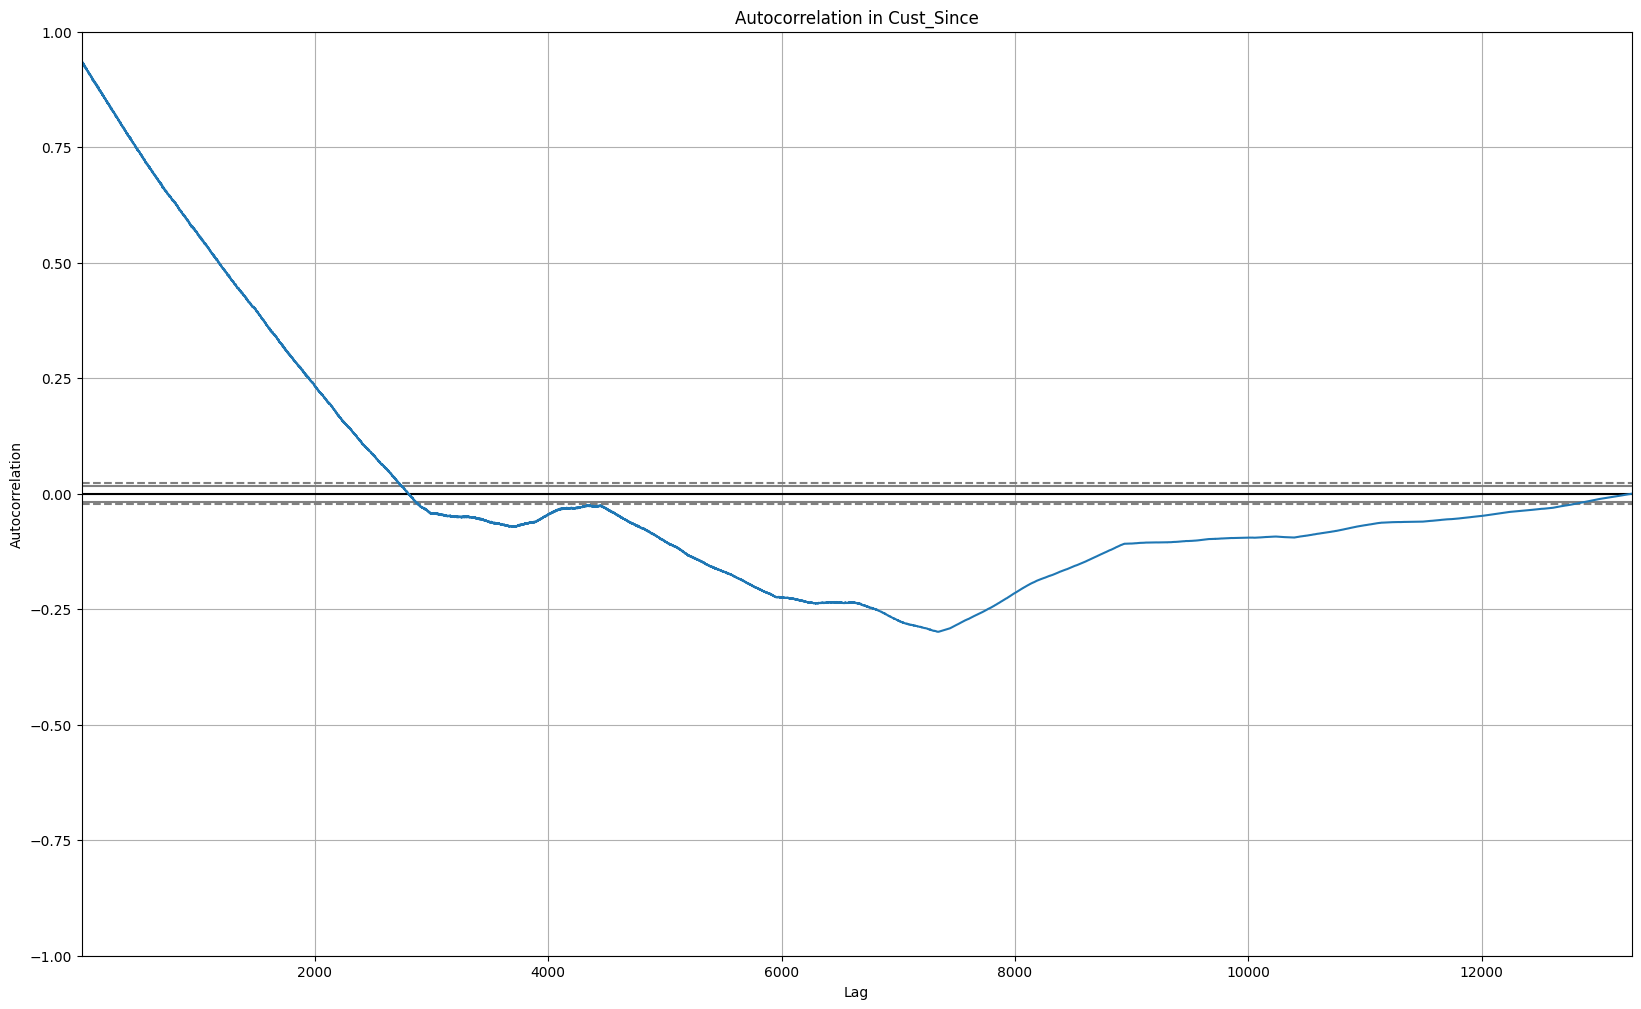

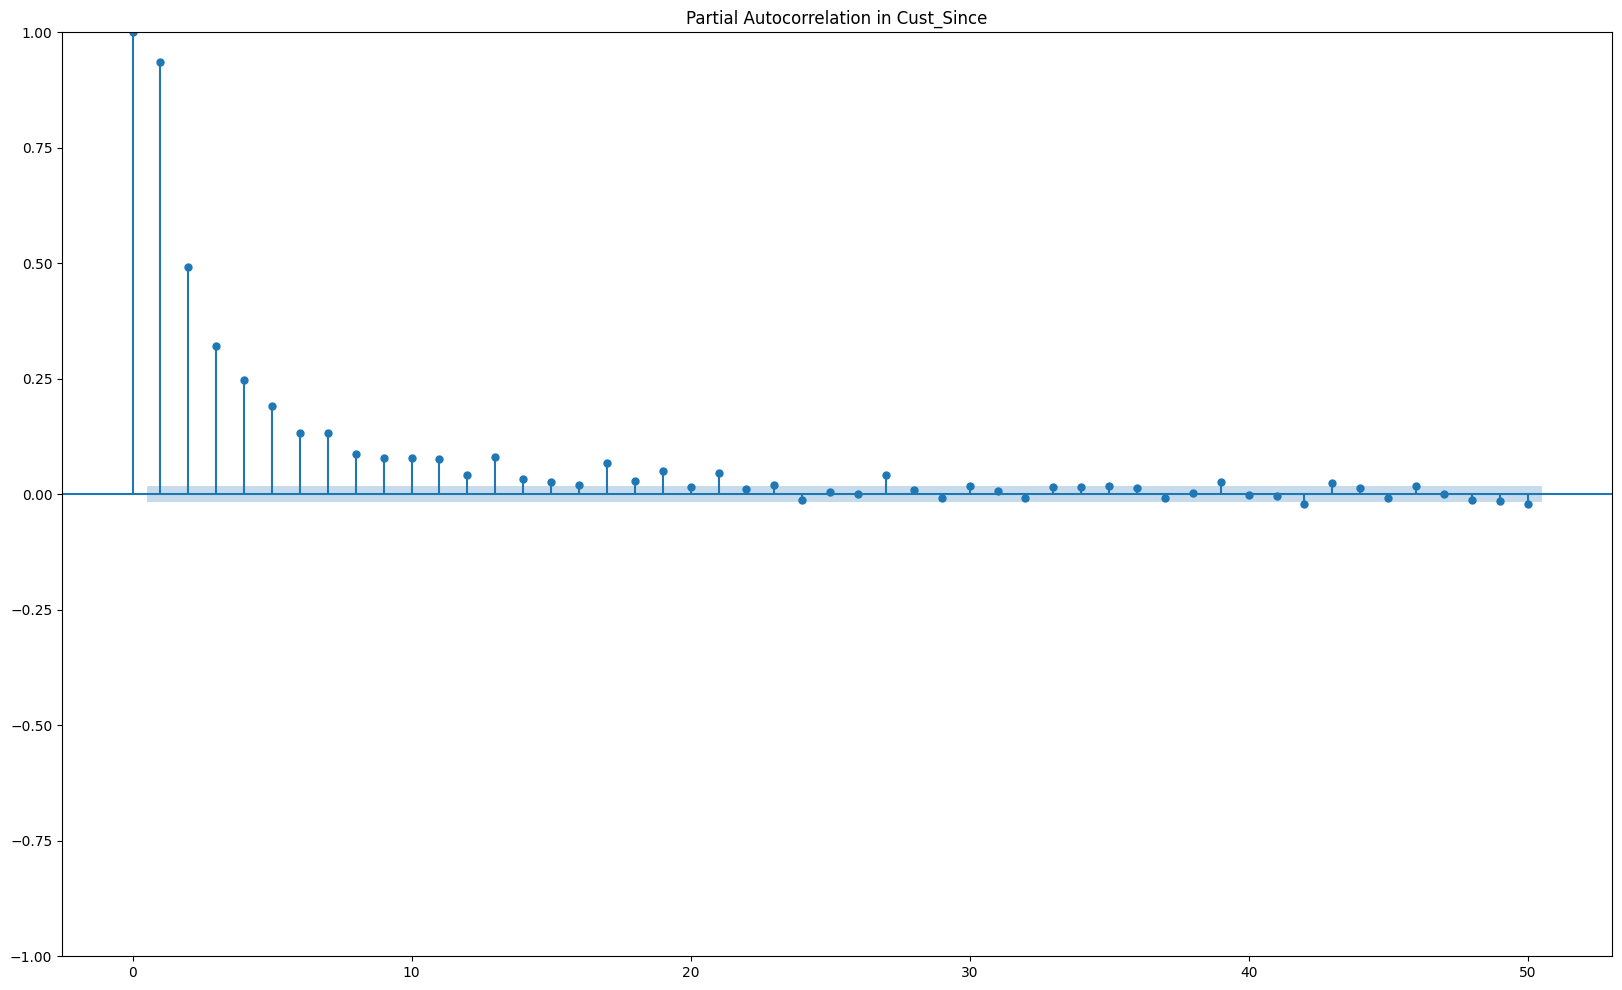

In [ ]:
# Import necessary libraries
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrelation Plot for 'Cust_Since'
autocorrelation_plot(df['Cust_Since'].dropna())
plt.title('Autocorrelation in Cust_Since')
plt.show()

# Partial Autocorrelation Plot for 'Cust_Since'
plot_pacf(df['Cust_Since'].dropna(), lags=50)
plt.title('Partial Autocorrelation in Cust_Since')
plt.show()

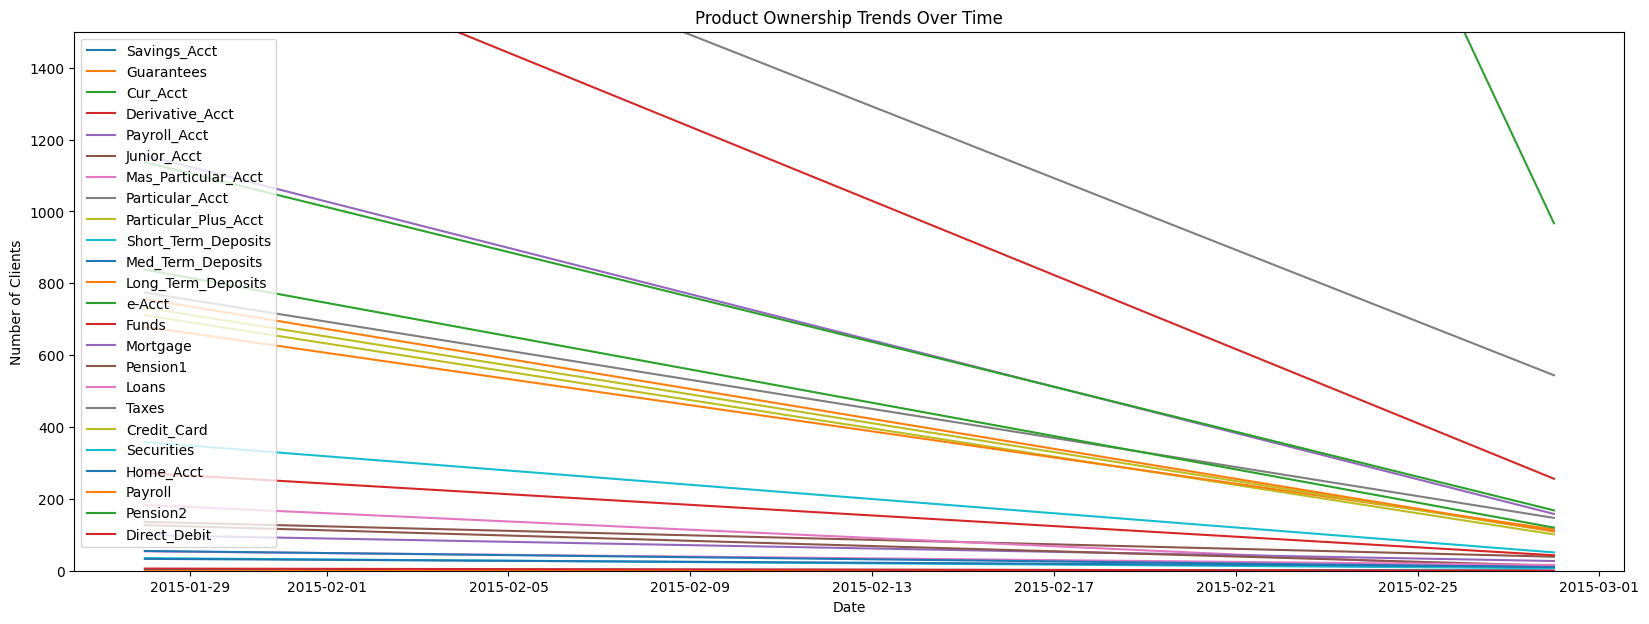

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Group by time and count the number of clients owning each product
product_ownership = df.groupby('Status_Dt')[['Savings_Acct', 'Guarantees', 'Cur_Acct', 'Derivative_Acct', 'Payroll_Acct', 'Junior_Acct',
                                             'Mas_Particular_Acct', 'Particular_Acct', 'Particular_Plus_Acct', 'Short_Term_Deposits',
                                             'Med_Term_Deposits', 'Long_Term_Deposits', 'e-Acct', 'Funds', 'Mortgage',
                                             'Pension1', 'Loans', 'Taxes', 'Credit_Card', 'Securities', 'Home_Acct',
                                             'Payroll', 'Pension2', 'Direct_Debit']].sum()


# Adjusting the y-axis to zoom in
plt.figure(figsize=(20,7))
for column in product_ownership.columns:
    plt.plot(product_ownership.index, product_ownership[column], label=column)

plt.title('Product Ownership Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Clients')
plt.ylim(0, 1500)  # Adjust this value as needed to zoom in on the relevant range
plt.legend(loc='upper left')
plt.show()



handling missing values of categorial and numeric values

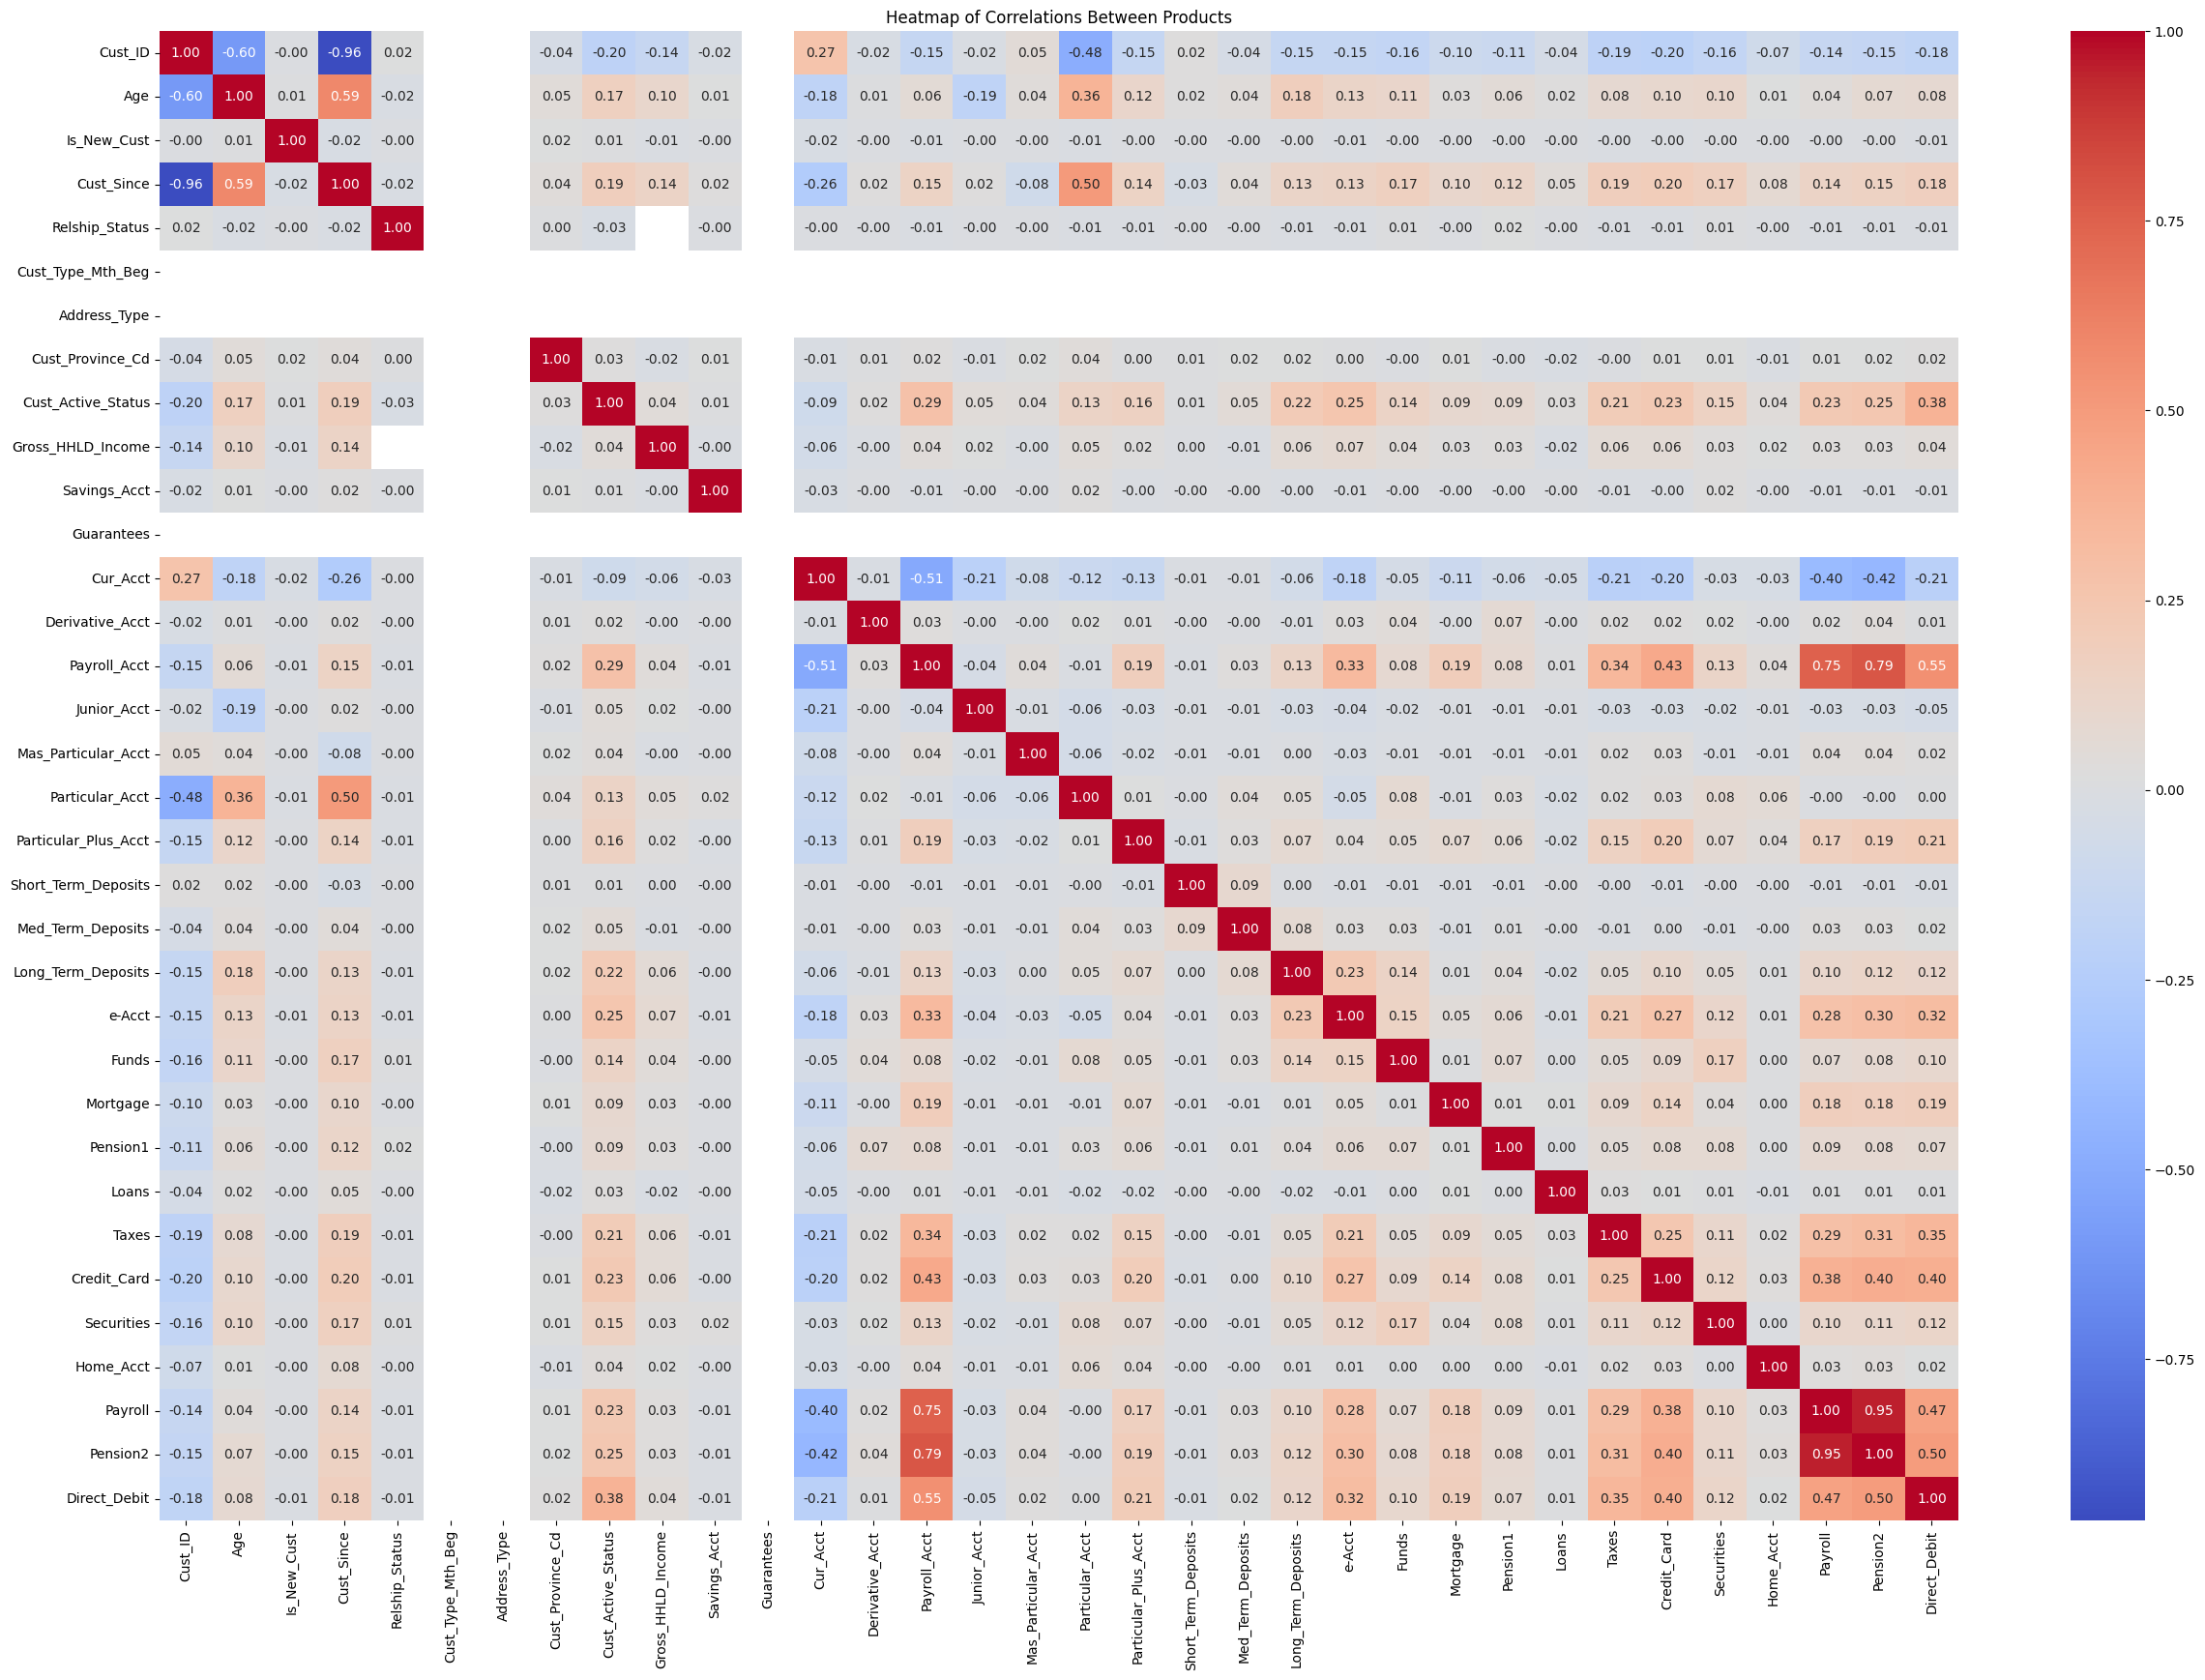

In [ ]:
# Select only numeric columns for correlation matrix
numeric_df = df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(30,20))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Heatmap of Correlations Between Products')
plt.show()

# Let's get down, let's get down to business! 🕺💃 👷

After understanding our data better, we would like to train a model to predict the following products a client is about to add or remove.

The development will be segmented into *three* steps.

1.   Create a label vector for each month:
<br>The label vector for each `<client, date>` is the *difference* between the products the client holds in `<date>` and the products of the same client in the consecutive month.<br>
For example, if a client `X` holds a credit card, and does not have a loan or a savings account in March 2019 (translates to the vector `[1,0,0]`) and canceled the credit card in April 2019 but opened a savings account (translates to the vector `[0,0,1]`) - The label for `X, March 2019` will be `[-1,0,1].` <br><br>

2.   Use Feature engineering and Feature selection methods to enrich the training dataset.

3. Use any relevant classification algorithm to predict the shift between consecutive months.
  


## Create labels

In [ ]:
# Step 1: Convert Status_Dt to the start of the month
df['Status_Dt'] = pd.to_datetime(df['Status_Dt']).dt.to_period('M').dt.to_timestamp()

# Step 2: Sort the data by Cust_ID and Status_Dt to ensure proper calculation of consecutive months
df = df.sort_values(by=['Cust_ID', 'Status_Dt'])

# Step 3: Create a shifted Status_Dt for the next month for each customer
df['Status_Dt_shifted'] = df.groupby('Cust_ID')['Status_Dt'].shift(-1)

# Step 4: Define the list of product columns to track
product_columns = ['Savings_Acct', 'Guarantees', 'Cur_Acct', 'Derivative_Acct', 'Payroll_Acct',
                   'Junior_Acct', 'Mas_Particular_Acct', 'Particular_Acct', 'Particular_Plus_Acct',
                   'Short_Term_Deposits', 'Med_Term_Deposits', 'Long_Term_Deposits', 'e-Acct',
                   'Funds', 'Mortgage', 'Pension1', 'Loans', 'Taxes', 'Credit_Card',
                   'Securities', 'Home_Acct', 'Payroll', 'Pension2', 'Direct_Debit']

# Step 5: Calculate the change in product status between consecutive months for each customer
for product in product_columns:
    df[product + '_change'] = df.groupby('Cust_ID')[product].diff(periods=-1)

# Step 6: Create the next_data_label dataframe with required columns: Cust_ID, Status_Dt, Status_Dt_shifted, and the 24 product change columns
next_data_label = df[['Cust_ID', 'Status_Dt', 'Status_Dt_shifted'] + [product + '_change' for product in product_columns]]

# Step 7: Drop rows where Status_Dt_shifted is NaT (last month for each customer with no following month)
next_data_label = next_data_label.dropna(subset=['Status_Dt_shifted'])

# Step 8: Replace NaN values in the product change columns with 0 (indicating no change in product status if missing)
next_data_label.fillna(0, inplace=True)

# Final verification of the dataframe
print(next_data_label.head())
print(next_data_label.shape)  # Should confirm 27 columns (Cust_ID, Status_Dt, Status_Dt_shifted, 24 product change columns)


        Cust_ID  Status_Dt Status_Dt_shifted  Savings_Acct_change  \
572707   418025 2015-01-01        2015-02-01                  0.0   
572681   418242 2015-01-01        2015-02-01                  0.0   
572926   418443 2015-01-01        2015-02-01                  0.0   
572909   418462 2015-01-01        2015-02-01                  0.0   
572802   418518 2015-01-01        2015-02-01                  0.0   

        Guarantees_change  Cur_Acct_change  Derivative_Acct_change  \
572707                0.0              0.0                     0.0   
572681                0.0              0.0                     0.0   
572926                0.0              0.0                     0.0   
572909                0.0              0.0                     0.0   
572802                0.0              0.0                     0.0   

        Payroll_Acct_change  Junior_Acct_change  Mas_Particular_Acct_change  \
572707                  0.0                 0.0                         0.0   
572681

In [ ]:
# i wont use this part because i want also 0 changes to capture full context information.
# # Because we only care about behavioural changes, we filter rows with no product change in the consecutive month.
# trainable_objects = next_data_label.iloc[:,3:].any(axis=1).to_numpy().nonzero()[0]
# next_data_label_relevant = next_data_label.iloc[trainable_objects]

## Create features

#### Feature engineering 👨‍🔧 📏 📝 📊
Feature engineering is a crucial part of working with tabular data.

We love new libraries and papers and try to be up-to-date as much as possible here at Insait.

Use any feature engineering method or library you know and love, and create new features to enrich your data.
You can choose to do automatic feature engineering or knowledge-based by manually thinking on logical correlations.

 Encoding Strategy:
For each categorical variable, we should evaluate whether it has an inherent order or if it’s purely nominal.
Nominal: [Cust_Ctry, Cust_Sex, Emp_Status, Residence_Ctry, Is_Foreigner, Is_Spouse_Emp, Deceased_Flg, Cust_Province_Cd, Cust_Province_Name, Join_Channel].
Logic: Since Nominal variables don’t have a natural order, we’ll apply one-hot encoding. This creates a new binary column for each unique category in the original column. The logic ensures that the model doesn’t assume any unintended order.
Execution: We'll create dummy variables using one-hot encoding for each nominal variable, ensuring that new columns are created and the original column is dropped (can be also kept by preference)
Potentially Ordinal: [Cust_Type_Mth_Beg, Cust_Relship_Type_Mth_Beg, Cust_Segment].
Logic: If the variable is ordinal, label encoding assigns a unique integer to each category based on their order. This preserves the ordinal relationship.
Execution: 1. We'll Ensure that the order is defined correctly to prevent misinterpretation.
           2. We'll apply label encoding to ordinal variables, where the categories are mapped to integers reflecting their order.
Check for Dummy Variable Trap - We'll ensure that one column from each one-hot encoded variable is dropped to avoid multicollinearity.
Verify that all categorical columns have been encoded correctly and that the dataset is ready for further analysis.


In [ ]:
# Creating enriched_df for further processing instead of using df

# Handling Missing Values for Categorical Columns
enriched_df = df.copy()

# Handle Deceased_Flg and Is_Spouse_Emp
enriched_df['Deceased_Flg'] = enriched_df['Deceased_Flg'].fillna(0)  # Assume alive if missing
enriched_df['Is_Spouse_Emp'] = enriched_df['Is_Spouse_Emp'].fillna(0)  # Assume no spouse employed in the same company

# Handle Join_Channel and Cust_Segment by creating a 'Missing' category
enriched_df['Join_Channel'] = enriched_df['Join_Channel'].fillna(0)
enriched_df['Cust_Segment'] = enriched_df['Cust_Segment'].fillna(0)

# Handle other categorical columns with mode imputation
categorical_columns = ['Emp_Status', 'Cust_Ctry', 'Cust_Sex', 'Cust_Type_Mth_Beg', 'Cust_Relship_Type_Mth_Beg', 'Residence_Ctry']
for col in categorical_columns:
    enriched_df[col] = enriched_df[col].fillna(enriched_df[col].mode()[0])  # Fill missing values with the most frequent value (mode)

# Numeric Columns

# Interpolation for numeric columns
numeric_columns = ['Age', 'Cust_Since', 'Gross_HHLD_Income']
for col in numeric_columns:
    enriched_df[col] = enriched_df[col].interpolate(method='linear')  # Linear interpolation for temporal continuity

# Filling with 0 for columns with more than 95% missing data
high_missing_columns = ['Lst_Dt_Primary_Cust', 'Is_Spouse_Emp']
for col in high_missing_columns:
    if enriched_df[col].isnull().mean() > 0.95:
        enriched_df[col] = enriched_df[col].fillna(0)

# Custom function to standardize the 'Cust_Type_Mth_Beg' column
def standardize_cust_type(value):
    if isinstance(value, str) and value.replace('.', '', 1).isdigit():
        return str(float(value))  # Convert '1', '1.0' -> '1.0'
    return value  # Keep alphabetic and float values as is

# Apply standardization to Cust_Type_Mth_Beg
enriched_df['Cust_Type_Mth_Beg'] = enriched_df['Cust_Type_Mth_Beg'].apply(standardize_cust_type)
enriched_df['Cust_Type_Mth_Beg'] = enriched_df['Cust_Type_Mth_Beg'].astype(str)

# Check for NaNs after filling
label_columns = ['Deceased_Flg', 'Is_Spouse_Emp', 'Join_Channel', 'Cust_Segment', 'Emp_Status', 'Cust_Ctry', 'Cust_Sex', 'Cust_Type_Mth_Beg', 'Cust_Relship_Type_Mth_Beg', 'Residence_Ctry']

print(enriched_df[label_columns].isnull().sum())  # Should print zeros if everything is correctly handled


Deceased_Flg                 0
Is_Spouse_Emp                0
Join_Channel                 0
Cust_Segment                 0
Emp_Status                   0
Cust_Ctry                    0
Cust_Sex                     0
Cust_Type_Mth_Beg            0
Cust_Relship_Type_Mth_Beg    0
Residence_Ctry               0
dtype: int64


In [ ]:
# Numeric And Categorical Encoding for enriched_df

from sklearn.preprocessing import LabelEncoder

# Initialize enriched_df
label_encoder = LabelEncoder()

# Apply One-Hot Encoding
one_hot_columns = ['Cust_Ctry', 'Cust_Sex', 'Residence_Ctry', 'Is_Foreigner',
                   'Is_Spouse_Emp', 'Deceased_Flg', 'Cust_Province_Name',
                   'Emp_Status', 'Join_Channel']

# Verify that all columns to be one-hot encoded exist in enriched_df
existing_one_hot_columns = [col for col in one_hot_columns if col in enriched_df.columns]

if existing_one_hot_columns:
    # One-Hot Encoding
    enriched_df = pd.get_dummies(enriched_df, columns=existing_one_hot_columns, drop_first=True)
else:
    print("No columns left available for one-hot encoding in the current DataFrame.")

# Apply Label Encoding
label_columns = ['Cust_Segment', 'Cust_Type_Mth_Beg', 'Cust_Relship_Type_Mth_Beg']

# Check for existence of label encoding columns before processing
for col in label_columns:
    if col in enriched_df.columns:
        enriched_df[col] = enriched_df[col].fillna('Unknown').astype(str)  # Ensure all entries are strings
        enriched_df[col] = label_encoder.fit_transform(enriched_df[col])
    else:
        print(f"Column {col} not found in DataFrame for label encoding.")

# Print the first few rows to verify encoding
print(enriched_df.head())


        Status_Dt  Cust_ID   Age    Join_Dt  Is_New_Cust  Cust_Since  \
416995 2015-01-28    15979  49.0 1995-01-16          0.0       246.0   
416922 2015-01-28    16093  60.0 1995-02-21          0.0       245.0   
417060 2015-01-28    16522  47.0 2003-07-31          0.0       144.0   
416655 2015-01-28    16603  69.0 1995-04-21          0.0       243.0   
416647 2015-01-28    16617  51.0 1995-05-18          0.0       107.0   

        Relship_Status Lst_Dt_Primary_Cust  Cust_Type_Mth_Beg  \
416995             1.0                   0                  0   
416922             1.0                   0                  0   
417060             1.0                   0                  0   
416655             1.0                   0                  0   
416647             1.0                   0                  0   

        Cust_Relship_Type_Mth_Beg  ...  Join_Channel_KGW  Join_Channel_KGX  \
416995                          0  ...             False             False   
416922              

#### Feature Selection
The financial datasets we use at Insait have hundreds of columns.

Training on such massive datasets lead to bad performance and extended training time.

Suggest a feature selection method (Using an open-source library is welcomed), and filter the provided dataset

In [ ]:
# Assuming next_data_label_relevant has been created and contains the change columns
# Merge the moving averages and other features from enriched_df with next_data_label_relevant

# Define the relevant columns from enriched_df to keep (excluding original features if not needed)
columns_to_keep = [col for col in enriched_df.columns if col not in product_columns]

# Merge on Cust_ID and Status_Dt
final_df = pd.merge(next_data_label_relevant, enriched_df[columns_to_keep], on=['Cust_ID', 'Status_Dt'], how='left')


NameError: name 'enriched_df' is not defined

In [ ]:
# 2. Merge the enriched_selected_df with the labels (the products difference vector <next_data_label_relevant>)
# Call the final df `features_labels`

# Merge the enriched features with the labels
features_labels = pd.merge(enriched_selected_df, next_data_label_relevant,
                           how='inner',
                           left_on=['Cust_ID_x', 'Status_Dt'],
                           right_on=['Cust_ID_x', 'Status_Dt'])

# Display the first few rows of the final DataFrame
print(features_labels.head())


## Modeling

In [ ]:
# Beware! a random train,test split will not work here, as we will leak data to future occurances.
# We will take samples where the next month in the last month in the db as our testing data, and the rest as train.

next_date_last = (features_labels.Status_Dt_shifted == features_labels.Status_Dt_shifted.max())
train, test = features_labels[next_date_last], features_labels[~next_date_last]

## Training
### It's the final countdown 🍒👷

In [ ]:
# We provide below a helper to preprocess the training features before entering to the model.
from sklearn.preprocessing import LabelEncoder
def prepare_for_model(df):
  features = df.loc[:,~df.columns.str.endswith('_change')].drop(['Cust_ID','Status_Dt'],axis=1)
  labels = df.loc[:,df.columns.str.endswith('_change')]
  features.loc[:,features.dtypes=='object'] = features.loc[:,features.dtypes=='object'].astype('category')

  features = features.drop(['Join_Dt','Status_Dt_shifted','Lst_Dt_Primary_Cust'],axis=1)
  features['Cust_Type_Mth_Beg'] = pd.to_numeric(features.Cust_Type_Mth_Beg, errors='coerce')

  for column in features.columns[features.dtypes == 'category']:
    features[column] = LabelEncoder().fit_transform(features[column])
  return features, labels

train_features, train_labels = prepare_for_model(train)
test_features, test_labels = prepare_for_model(test)

In [ ]:
# There are several months where a client changed more than one item.
# Thus we are looking at a multioutput classification problem.
# Use any algorithm/ platform/ library you desire and train the above `train_features, train_labels`.
# Test on test_labels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

###### Your Code Here ######



In [ ]:
# Evaluation code
for idx,col in enumerate(test_labels.columns):
  cm = confusion_matrix(test_labels[col].values,yhat[:,idx])
  cr = classification_report(test_labels[col].values,yhat[:,idx])
  print(f"Label: {col} \nconf\n {cm}, \nreport\n {cr}\n")


What you can say about the results?

# This is it!
We hope you enjoyed this notebook.
Please share your thoughts and impressions, and send us a link to your notebook.
Talk to you soon:)